# Peptide Bioactivity Prediction (Ensemble ML)
**Author:** Yasaman Behzadipour, Pharm.D.

**Project Overview:**
This notebook implements a Voting Ensemble Classifier to predict peptide function (Cell-Penetrating Peptides) using 566 physicochemical features extracted via AAindex.

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [14]:
# 1. Load Data
print("🚀 Loading Data...")
# Load Labels
df_seq = pd.read_csv('DupDroped.csv') 
y = df_seq['Class']

# Load Features (Already calculated)
df_features = pd.read_csv('Output.csv')
# Remove index column if present
if 'Unnamed: 0' in df_features.columns:
    df_features = df_features.drop(columns=['Unnamed: 0'])
X = df_features

🚀 Loading Data...


In [15]:
# 2. Alignment Check
if len(X) != len(y):
    print(f"⚠️ Alignment Warning: X={len(X)}, y={len(y)}")
    # Truncate to matching length if needed (safety check)
    min_len = min(len(X), len(y))
    X = X.iloc[:min_len]
    y = y[:min_len]

In [16]:
# 3. Preprocessing
# Convert labels to 0/1
le = LabelEncoder()
y_enc = le.fit_transform(y.astype(str))

# Handle any NaNs and Scale features (Critical for SVM/KNN)
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

In [17]:
# 4. Define Models
models = [
    ('Random Forest', RandomForestClassifier(n_estimators=100, random_state=42)),
    ('KNN', KNeighborsClassifier(n_neighbors=5)),
    ('SVM', SVC(probability=True, random_state=42)),
    ('Decision Tree', DecisionTreeClassifier(random_state=42)),
    ('Naive Bayes', GaussianNB())
]

In [18]:
# 5. Evaluation
# Stratified split ensures equal balance of classes in train/test
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_enc, test_size=0.2, random_state=42, stratify=y_enc
)

print("\n📊 Model Results:")
for name, model in models:
    model.fit(X_train, y_train)
    acc = model.score(X_test, y_test)
    print(f"   • {name:<15} {acc:.2%}")



📊 Model Results:
   • Random Forest   86.67%
   • KNN             86.39%
   • SVM             87.22%
   • Decision Tree   78.06%
   • Naive Bayes     81.11%


In [19]:
# 6. Train Ensemble
ensemble = VotingClassifier(estimators=models, voting='soft')
ensemble.fit(X_train, y_train)
y_pred = ensemble.predict(X_test)
ens_acc = accuracy_score(y_test, y_pred)

print("-" * 30)
print(f"🏆 Ensemble Accuracy: {ens_acc:.2%}")
print("-" * 30)


------------------------------
🏆 Ensemble Accuracy: 84.44%
------------------------------



Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.90      0.88       231
           1       0.80      0.75      0.78       129

    accuracy                           0.84       360
   macro avg       0.83      0.82      0.83       360
weighted avg       0.84      0.84      0.84       360



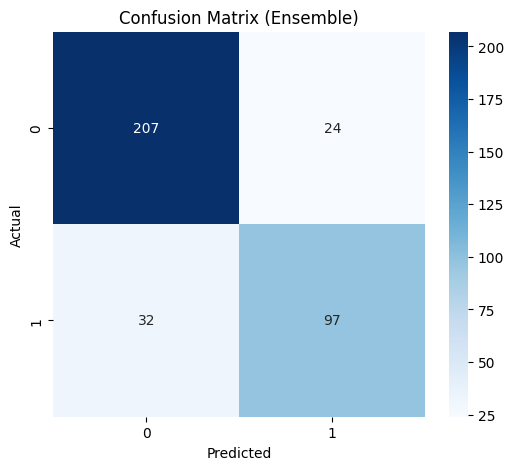

In [20]:
# 7. Visualization
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix (Ensemble)')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()